This notebook simplified the implementation of https://github.com/aspuru-guzik-group/GA. See Nigam et al., 2020.

In [1]:
import pandas as pd
import selfies as slf
import numpy as np
from rdkit.Chem import Descriptors
from rdkit import Chem
import rdkit

rdkit.RDLogger.DisableLog('rdApp.*')

print("pandas\t", pd.__version__)
print("numpy\t", np.__version__)
print("rdkit\t", rdkit.__version__)
print("selfies\t", slf.__version__)


pandas	 2.1.1
numpy	 1.26.0
rdkit	 2023.03.3
selfies	 2.1.0


In [2]:
# Get dataset
# Tox21 data: Qualitative toxicity measurements on 12 biological targets, 
#             including nuclear receptors and stress response pathways [classification]
url = (
    "https://raw.githubusercontent.com/GLambard/Molecules_Dataset_Collection/master/latest/tox21.csv"
)
dataset = pd.read_csv(url)

We will use SELFIES representation for molecules, since it is 100% valid under any perturbations.

First, we define "alphabet" of the molecules.

In [ ]:
# transform to SELFIES
selfies_strings = dataset.smiles.apply(slf.encoder)

# "alphabet" is a set of tokens
alphabet = list(slf.get_alphabet_from_selfies(selfies_strings))

Mutation rule: 50% insertions or 50% replacements of single SELFIES characters.

In [41]:

def _is_valid(smi):
    try:
        mol = Chem.MolFromSmiles(smi, sanitize=True)
        smi_canon = Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)
        if len(smi_canon) == 0:
            return False
        else:
            return True
    except:
        return False


def random_mutation(selfie, alphabet):
    
    chars_selfie = list(slf.split_selfies(selfie))
    valid = False
    for _ in range(30):
        # Insert a character in a Random Location
        if np.random.random() < 0.5: 
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]
    
            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]
    
        # Replace a random character 
        else:                         
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]

        selfie_mutated = ''.join(selfie_mutated_chars)
        smiles = slf.decoder(selfie_mutated)
        if _is_valid(smiles):
            break

    return selfie_mutated

print("original", population[1])
print("mutated ", random_mutation(population[1], alphabet))

original [C][C][N][C][=Branch1][C][=O][N][C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Ring1][N][=O]
mutated  [C][C][N][C][=Branch1][C][=O][N][C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][C@H1][C][Ring1][N][=O]


We will use logP as a fitness score (high logP = high lipophilicity).

In [42]:
def _safe_logP(mol):
    try: 
        score = Descriptors.MolLogP(mol)
    except: # invalid molecule
        score = -1
    return score


def evaluate_fitness(selfies):
    fitness = []
    for selfie in selfies:
        smi = slf.decoder(selfie)
        mol = Chem.MolFromSmiles(smi)
        fitness += [_safe_logP(mol)]
    return np.array(fitness)

evaluate_fitness(population[:4])

array([1.3424 , 1.2994 , 5.0903 , 3.75244])

We replace molecules to mutations of higher-fit molecules.

In [43]:
def _apply_generation_cutoff(fitness):
    rank = np.argsort(np.argsort(fitness))
    z = 5 * rank / len(rank) - 2
    probabilities = 1 / (1 + np.exp(-z))
    
    to_replace = [] # all molecules that are replaced 
    to_keep    = [] # all molecules that are kept 
    for idx in range(len(rank)):
        if np.random.rand(1) > probabilities[idx]:
            to_replace.append(idx)
        else:
            to_keep.append(idx)

    return to_replace, to_keep

def replace_next_gen_molecules(selfies, fitness, alphabet):
    to_replace, to_keep = _apply_generation_cutoff(fitness)
    
    for idx in to_replace:
        # smiles to replace (by better molecules)
        random_index=np.random.choice(to_keep, size=1)[0]    # select a random molecule that survived
        selfies[idx] = random_mutation(selfies[random_index], alphabet)  # do the mutation
    return selfies


Note that logP can be optimized without bound, which results in unrealistic molecules.

In [49]:
from tqdm import tqdm

# population size: 500
population = dataset.smiles[:500].apply(slf.encoder).to_list()

avg_fit = []
pbar = tqdm(range(50))

for _ in pbar:
    fitness = evaluate_fitness(population)
    to_replace, to_keep = apply_generation_cutoff(fitness)
    replace_next_gen_molecules(population, to_replace, to_keep, alphabet)

    avg_fit.append(np.mean(fitness))

    pbar.set_postfix({"fitness": avg_fit[-1]})

100%|███████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s, fitness=25.5]


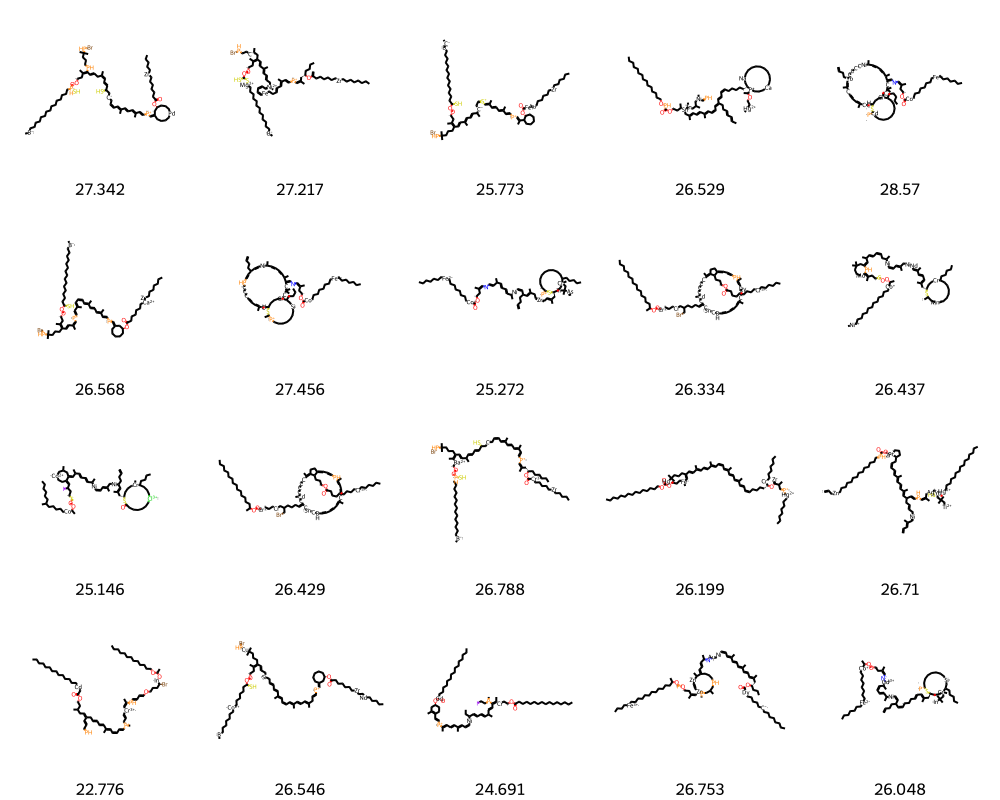

In [50]:

smiles = [slf.decoder(selfie) for selfie in population]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
legends = [str(round(x, 3)) for x in evaluate_fitness(population[:20])]

Chem.Draw.MolsToGridImage(mols[:20], molsPerRow=5, legends=legends)

# Reference

Nigam et al., Augmenting genetic algorithms with deep neural networks for exploring the chemical space, ICLR, 2020.